# Faster R-CNN (Pretrained) on C2A_Dataset
- Transfer learning with torchvision Faster R-CNN (ResNet50-FPN) pretrained on MS COCO
- On-the-fly augmentations: HSV, translate, scale, fliplr, rotation 15–30°, mosaic
- Visualize feature maps (3 layers) and dense activations (2 layers) for 5 selected images
- Train & Evaluate with performance graphs (Loss, Accuracy proxy, R2, MAE, MSE)
- Grad-CAM to illustrate correct vs incorrect focus regions

In [2]:
# Setup & Imports
import os, json, random, math, gc, time
from collections import defaultdict
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import albumentations as A
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Paths
DATASET_ROOT = './C2A_Dataset/new_dataset3'
SELECTED_DIR = './C2A_selected'
os.makedirs('checkpoints', exist_ok=True)

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Using device: cuda


In [ ]:
# Dataset with on-the-fly augmentation (bbox-safe, manual geometry)
import math

def load_yolo_annotations(yolo_label_path, img_width, img_height):
    boxes, labels = [], []
    if not os.path.exists(yolo_label_path):
        return torch.zeros((0,4), dtype=torch.float32), torch.zeros((0,), dtype=torch.int64)
    with open(yolo_label_path, 'r') as f:
        for line in f.readlines():
            vals = line.strip().split()
            if len(vals) < 5:
                continue
            x_center_norm, y_center_norm, width_norm, height_norm = map(float, vals[1:5])
            x_center = x_center_norm * img_width
            y_center = y_center_norm * img_height
            w = width_norm * img_width
            h = height_norm * img_height
            x_min = x_center - w/2; y_min = y_center - h/2
            x_max = x_center + w/2; y_max = y_center + h/2
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(1)
    return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

def pil_to_cv2(img_pil):
    arr = np.array(img_pil)
    return arr[:, :, ::-1]

def cv2_to_pil(img_cv):
    arr = img_cv[:, :, ::-1]
    return Image.fromarray(arr)

# Geometry helpers (pixel-space pascal_voc)
def clamp_xyxy(boxes, W, H, min_size=2):
    if len(boxes)==0:
        return boxes
    b = boxes.copy()
    b[:,0] = np.clip(b[:,0], 0, W-1)
    b[:,1] = np.clip(b[:,1], 0, H-1)
    b[:,2] = np.clip(b[:,2], 0, W-1)
    b[:,3] = np.clip(b[:,3], 0, H-1)
    x1 = np.minimum(b[:,0], b[:,2]); y1 = np.minimum(b[:,1], b[:,3])
    x2 = np.maximum(b[:,0], b[:,2]); y2 = np.maximum(b[:,1], b[:,3])
    b = np.stack([x1,y1,x2,y2], axis=1)
    ws = (b[:,2]-b[:,0]); hs=(b[:,3]-b[:,1])
    keep = (ws>=min_size) & (hs>=min_size)
    return b[keep]

def hflip_boxes(boxes, W):
    if len(boxes)==0:
        return boxes
    b = boxes.copy()
    x1,y1,x2,y2 = b[:,0],b[:,1],b[:,2],b[:,3]
    nx1 = (W-1) - x2
    nx2 = (W-1) - x1
    b[:,0], b[:,2] = nx1, nx2
    return b

def translate_boxes(boxes, tx, ty):
    if len(boxes)==0: return boxes
    b = boxes.copy()
    b[:,[0,2]] += tx
    b[:,[1,3]] += ty
    return b

def scale_boxes(boxes, sx, sy):
    if len(boxes)==0: return boxes
    b = boxes.copy()
    b[:,[0,2]] *= sx
    b[:,[1,3]] *= sy
    return b

def rotate_image_and_boxes(img, boxes, angle_deg):
    # rotate around image center; keep size using cv2.warpAffine
    H, W = img.shape[:2]
    center = (W/2.0, H/2.0)
    M = cv2.getRotationMatrix2D(center, angle_deg, 1.0)
    rotated = cv2.warpAffine(img, M, (W, H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(114,114,114))
    if len(boxes)==0:
        return rotated, boxes
    # convert boxes to 4 corner points and rotate
    b = boxes.copy()
    corners = []
    for x1,y1,x2,y2 in b:
        pts = np.array([[x1,y1],[x2,y1],[x2,y2],[x1,y2]], dtype=np.float32)
        ones = np.ones((4,1), dtype=np.float32)
        pts_h = np.hstack([pts, ones])
        pr = (M @ pts_h.T).T
        x_min, y_min = pr[:,0].min(), pr[:,1].min()
        x_max, y_max = pr[:,0].max(), pr[:,1].max()
        corners.append([x_min, y_min, x_max, y_max])
    b2 = np.array(corners, dtype=np.float32)
    b2 = clamp_xyxy(b2, W, H)
    return rotated, b2

class C2ACocoDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, augment=False, mosaic_prob=0.0):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.augment = augment
        self.mosaic_prob = 0.0  # disable mosaic to avoid bbox edge cases during training
        self.img_dir = os.path.join(root_dir, split, 'images')
        self.ann_path = os.path.join(root_dir, split, f'{split}_annotations.json')
        with open(self.ann_path, 'r') as f:
            self.coco_data = json.load(f)
        self.imgs = {img_info['id']: img_info for img_info in self.coco_data['images']}
        self.ids = list(self.imgs.keys())
        self.pose_labels_dir = os.path.join(root_dir, 'All labels with Pose information', 'labels')
        # Image-only HSV transform (Albumentations ok for image-only)
        self.img_only_tf = A.Compose([
            A.HueSaturationValue(hue_shift_limit=0.015*255, sat_shift_limit=0.7*255, val_shift_limit=0.4*255, p=0.9),
            A.RandomBrightnessContrast(p=0.5)
        ])
    def __len__(self):
        return len(self.ids)
    def _load_item(self, img_id):
        info = self.imgs[img_id]
        img_filename = info['file_name']
        img_path = os.path.join(self.img_dir, img_filename)
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        H, W = image.shape[:2]
        label_path = os.path.join(self.pose_labels_dir, os.path.splitext(img_filename)[0] + '.txt')
        boxes_t, labels_t = load_yolo_annotations(label_path, W, H)
        return image, boxes_t.numpy(), labels_t.numpy(), img_filename, W, H
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        image, boxes, labels, img_filename, W, H = self._load_item(img_id)
        boxes = clamp_xyxy(np.array(boxes, dtype=np.float32), W, H)
        # Augment (manual geometry)
        if self.augment and self.split=='train':
            # image-only HSV
            image = self.img_only_tf(image=image)['image']
            # fliplr 0.5
            if random.random() < 0.5:
                image = np.ascontiguousarray(image[:, ::-1, :])
                boxes = hflip_boxes(boxes, W)
                boxes = clamp_xyxy(boxes, W, H)
            # translate up to ±0.1, scale up to ±0.5 around center, rotate 15–30 deg
            # translate
            max_tx = 0.1 * W; max_ty = 0.1 * H
            tx = random.uniform(-max_tx, max_tx)
            ty = random.uniform(-max_ty, max_ty)
            M_t = np.float32([[1,0,tx],[0,1,ty]])
            image = cv2.warpAffine(image, M_t, (W,H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(114,114,114))
            boxes = translate_boxes(boxes, tx, ty)
            boxes = clamp_xyxy(boxes, W, H)
            # scale
            sx = 1.0 + random.uniform(-0.5, 0.5)
            sy = 1.0 + random.uniform(-0.5, 0.5)
            image = cv2.resize(image, (int(W*sx), int(H*sy)), interpolation=cv2.INTER_LINEAR)
            image = cv2.resize(image, (W, H), interpolation=cv2.INTER_LINEAR)
            boxes = scale_boxes(boxes, sx, sy)
            boxes = clamp_xyxy(boxes, W, H)
            # rotate in [15,30] or [-30,-15]
            deg = random.choice([1,-1]) * random.uniform(15.0, 30.0)
            image, boxes = rotate_image_and_boxes(image, boxes, deg)
            # final clamp
            boxes = clamp_xyxy(boxes, W, H)
        # ToTensor
        image_t = torch.from_numpy(image.astype(np.float32)/255.0).permute(2,0,1)
        target = {'boxes': torch.tensor(boxes, dtype=torch.float32), 'labels': torch.tensor(labels, dtype=torch.int64), 'image_id': torch.tensor([img_id])}
        if target['boxes'].numel()==0:
            target['boxes'] = torch.zeros((0,4), dtype=torch.float32)
            target['labels'] = torch.zeros((0,), dtype=torch.int64)
        return image_t, target

In [4]:
# Build COCO-pretrained Faster R-CNN (ResNet50-FPN)
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
try:
    from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT  # Pretrained on MS COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
    print('Loaded Faster R-CNN ResNet50-FPN with COCO weights (MS COCO).')
except Exception as e:
    print('Fallback to pretrained=True:', e)
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # background + 1 class
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

# Optimizer
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.002, momentum=0.9, weight_decay=5e-4)
print('Model ready (transfer learning from MS COCO).')

Loaded Faster R-CNN ResNet50-FPN with COCO weights (MS COCO).
Model ready (transfer learning from MS COCO).


In [ ]:
# Datasets & Loaders (with requested on-the-fly augmentations)
import torchvision.transforms as T

# Build datasets (mosaic disabled for stability)
train_ds = C2ACocoDataset(DATASET_ROOT, 'train', transform=None, augment=True, mosaic_prob=0.0)
val_ds   = C2ACocoDataset(DATASET_ROOT, 'val',   transform=None, augment=False, mosaic_prob=0.0)
test_ds  = C2ACocoDataset(DATASET_ROOT, 'test',  transform=None, augment=False, mosaic_prob=0.0)

# Collate function for detection models
def collate_fn(batch):
    return tuple(zip(*batch))

# Use cautious settings for Windows stability
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,  collate_fn=collate_fn, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=0)

print(f"Dataset sizes: train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")

Dataset sizes: train=6129, val=2043, test=2043


In [6]:
# Visualization hooks: feature maps (layer1,2,3) and dense activations (fc6, fc7)
feature_maps = defaultdict(list)
dense_acts = defaultdict(list)
HOOKS_ENABLED = False

def save_fmap(name):
    def hook(module, inp, out):
        if HOOKS_ENABLED:
            feature_maps[name].append(out.detach().cpu())
    return hook

# Access resnet body inside backbone (for ResNet50-FPN)
resnet_body = model.backbone.body
h1 = resnet_body.layer1.register_forward_hook(save_fmap('layer1'))
h2 = resnet_body.layer2.register_forward_hook(save_fmap('layer2'))
h3 = resnet_body.layer3.register_forward_hook(save_fmap('layer3'))

def save_dense(name, post_relu=False):
    def hook(module, inp, out):
        if HOOKS_ENABLED:
            t = torch.relu(out) if post_relu else out
            dense_acts[name].append(t.detach().cpu())
    return hook

h_fc6 = model.roi_heads.box_head.fc6.register_forward_hook(save_dense('fc6', post_relu=False))
h_fc7 = model.roi_heads.box_head.fc7.register_forward_hook(save_dense('fc7', post_relu=False))
print('Hooks registered. Enable HOOKS_ENABLED=True only when visualizing.')

def reset_hooks_buffers():
    feature_maps.clear(); dense_acts.clear()

Hooks registered. Enable HOOKS_ENABLED=True only when visualizing.


In [7]:
# Helpers for inference and plotting
from matplotlib import patches
@torch.no_grad()
def run_inference_with_hooks(model, img_tensor):
    model.eval()
    preds = model([img_tensor.to(device)])
    return preds[0]

def tensor_to_np(img_tensor):
    img = img_tensor.detach().cpu().permute(1,2,0).numpy()
    return np.clip(img, 0, 1)

def show_feature_maps(fmaps, axes=None, titles=('layer1','layer2','layer3')):
    if axes is None:
        fig = plt.figure(figsize=(15,4))
        axes = [plt.subplot(1,3,i+1) for i in range(3)]
        owns_fig = True
    else:
        owns_fig = False
    for i, k in enumerate(titles):
        ax = axes[i] if i < len(axes) else None
        if ax is None: continue
        lst = fmaps.get(k, [])
        if not lst:
            ax.set_title(k+' (no data)'); ax.axis('off'); continue
        fmap = lst[-1]
        if fmap.dim()==4: fmap=fmap[0]
        heat = fmap.mean(dim=0).numpy()
        ax.imshow(heat, cmap='hot'); ax.set_title(k); ax.axis('off')
    if owns_fig:
        plt.tight_layout(); plt.show(); plt.close()

def show_dense_activations(dacts, ax=None, topk=32, agg='first'):
    def get_vals(key):
        lst = dacts.get(key, [])
        if not lst: return np.zeros(topk)
        acts = lst[-1]
        if acts.numel()==0: return np.zeros(topk)
        vec = acts.mean(dim=0).numpy() if agg=='mean' else acts[0].numpy()
        idxs = np.argsort(-np.abs(vec))[:topk]
        return vec[idxs]
    if ax is None:
        fig, axs = plt.subplots(1,2, figsize=(16,5))
        vals1 = get_vals('fc6'); axs[0].bar(range(len(vals1)), vals1); axs[0].set_title(f'fc6 top-{topk} ({agg})')
        vals2 = get_vals('fc7'); axs[1].bar(range(len(vals2)), vals2); axs[1].set_title(f'fc7 top-{topk} ({agg})')
        for a in axs: a.grid(True)
        plt.tight_layout(); plt.show(); plt.close(fig)
    else:
        vals1 = get_vals('fc6'); ax.bar(range(len(vals1)), vals1); ax.set_title(f'fc6 top-{topk} ({agg})')

def draw_detections(ax, img_np, pred, score_thr=0.5):
    ax.imshow(img_np); ax.axis('off')
    boxes = pred.get('boxes', torch.zeros((0,4))).cpu().numpy()
    scores = pred.get('scores', torch.zeros(0)).cpu().numpy()
    for b, s in zip(boxes, scores):
        if s < score_thr: continue
        x1,y1,x2,y2 = b
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, edgecolor='lime', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1, f'{s:.2f}', color='yellow', fontsize=8, backgroundcolor='black')

Selected images path: d:\CodingD\Image-Processing-Proj\C2A_selected


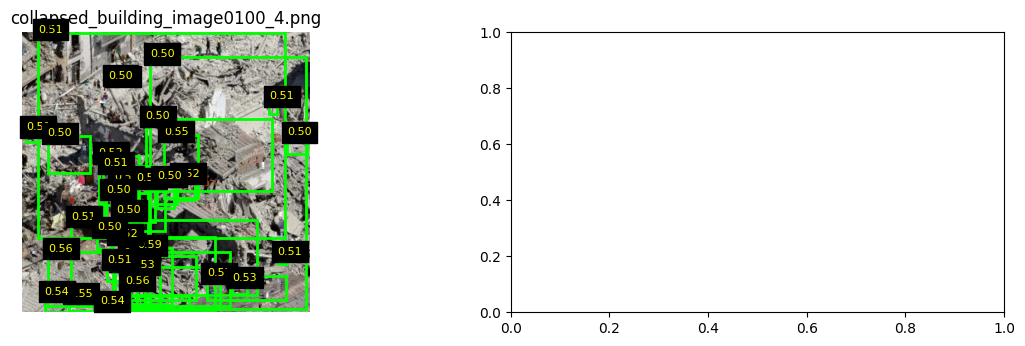

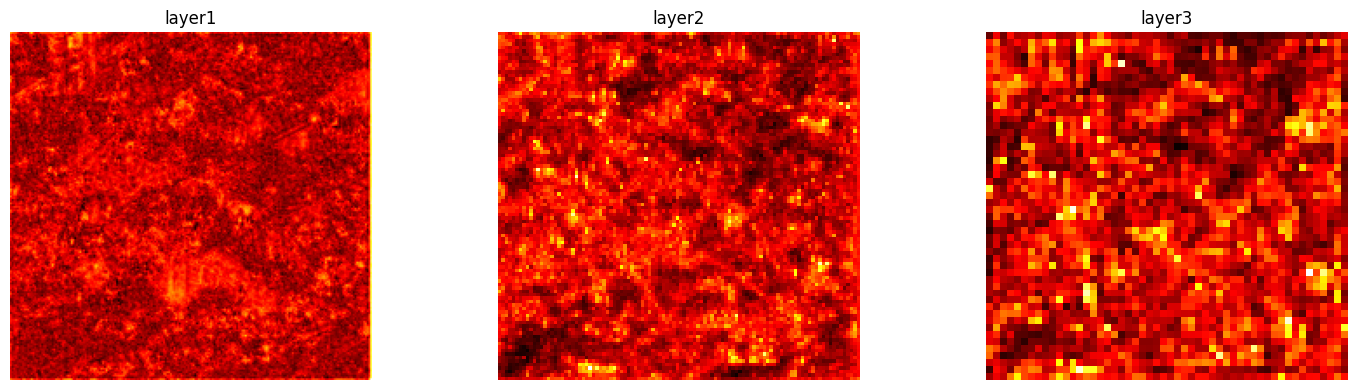

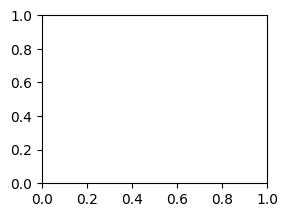

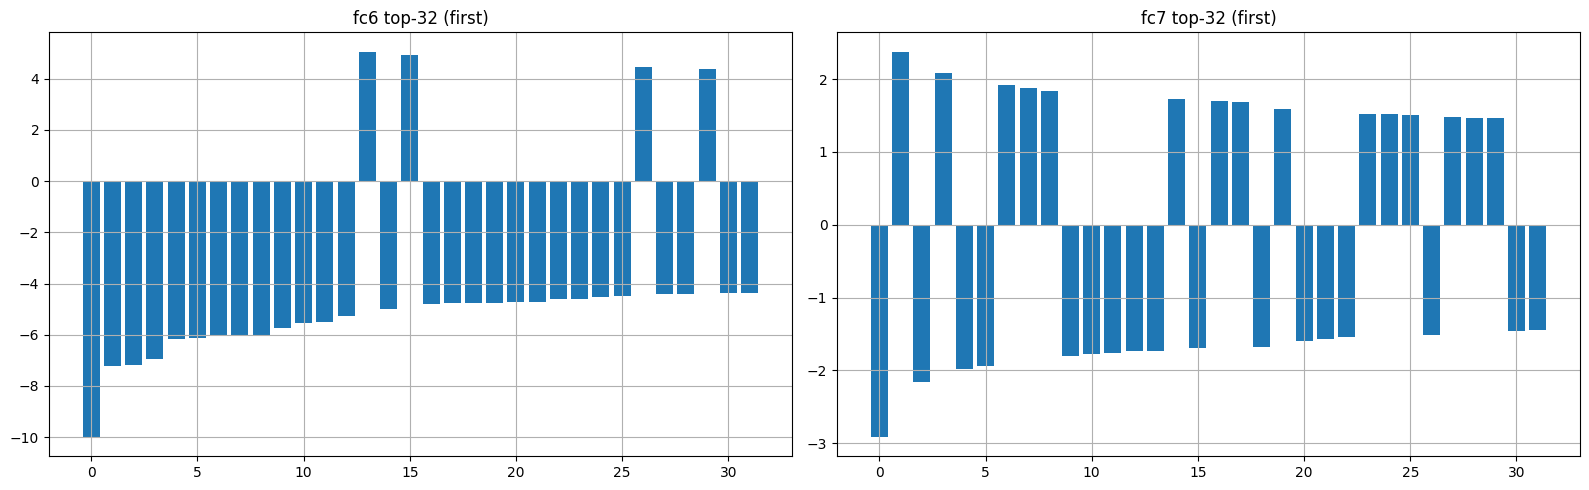

<Figure size 640x480 with 0 Axes>

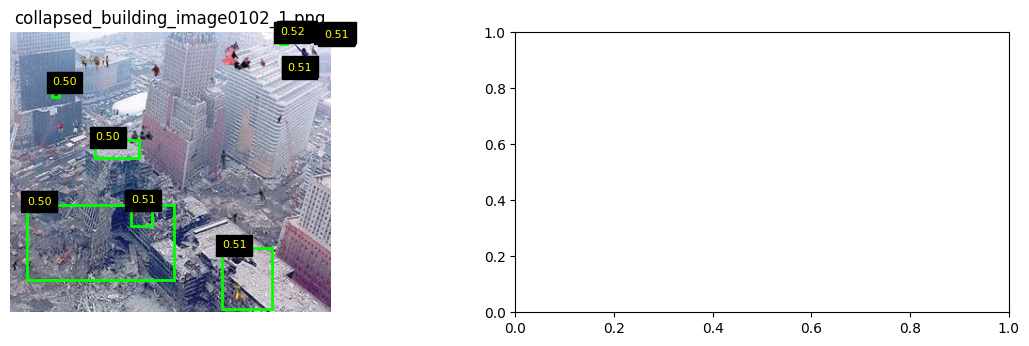

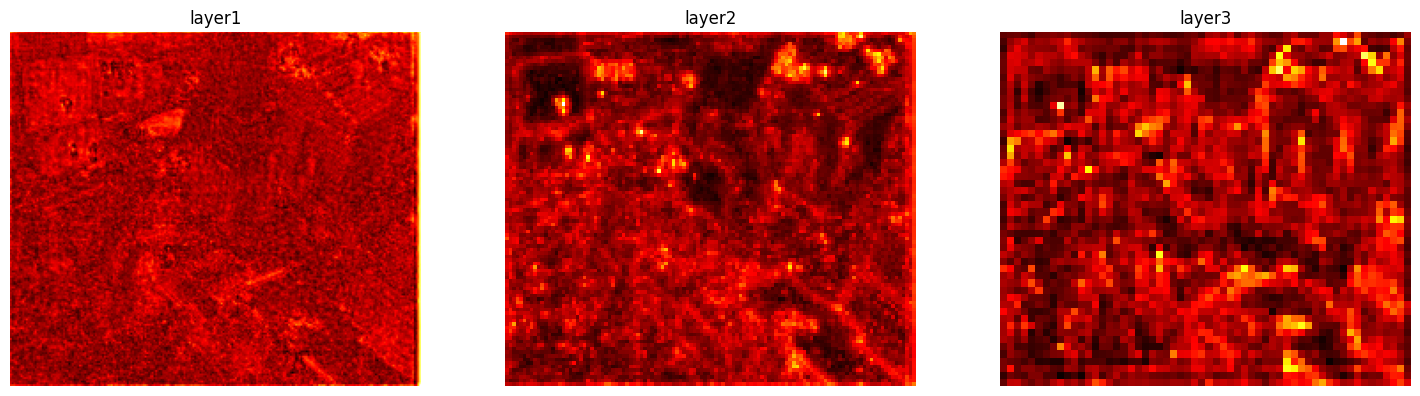

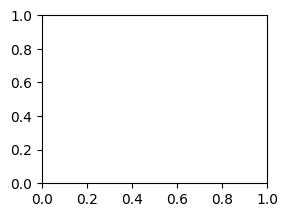

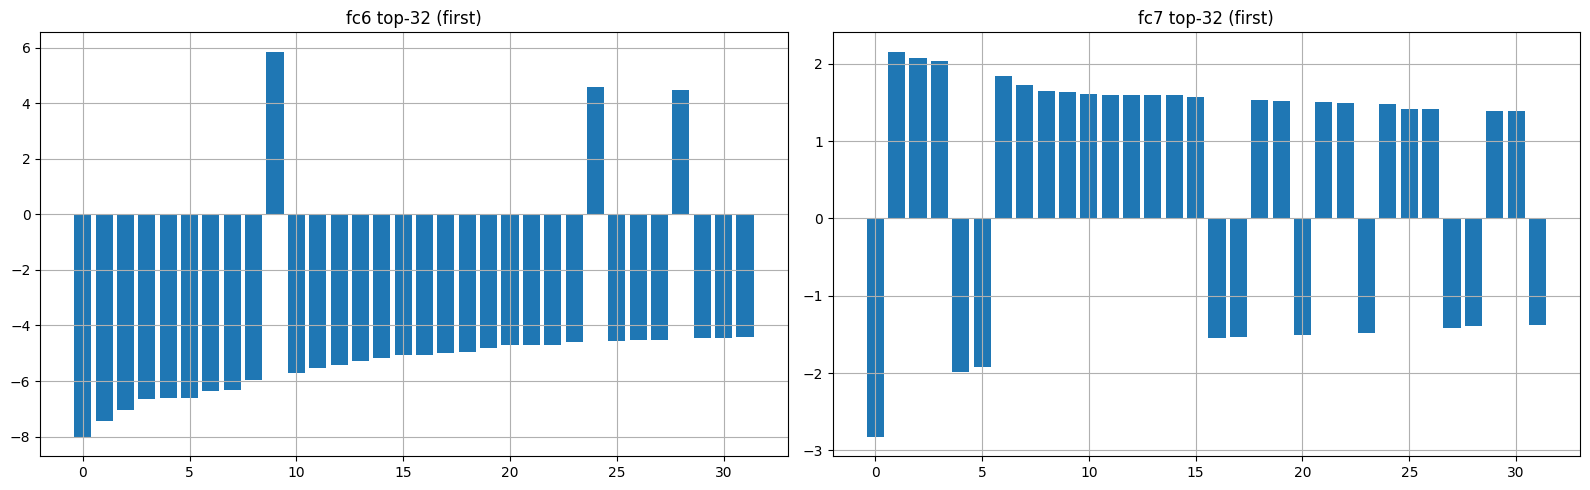

<Figure size 640x480 with 0 Axes>

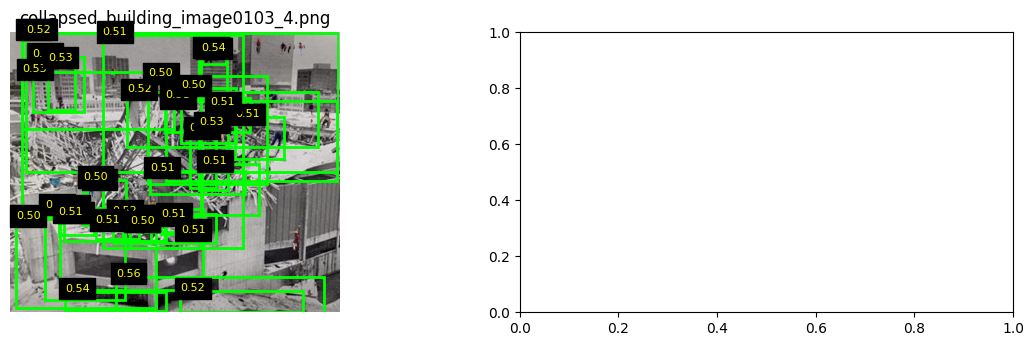

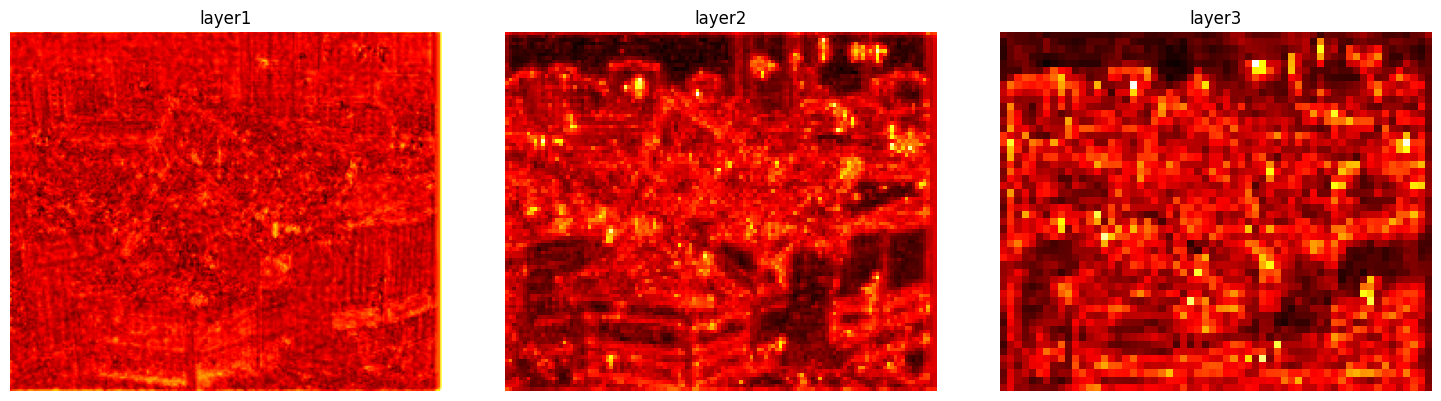

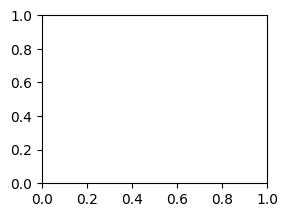

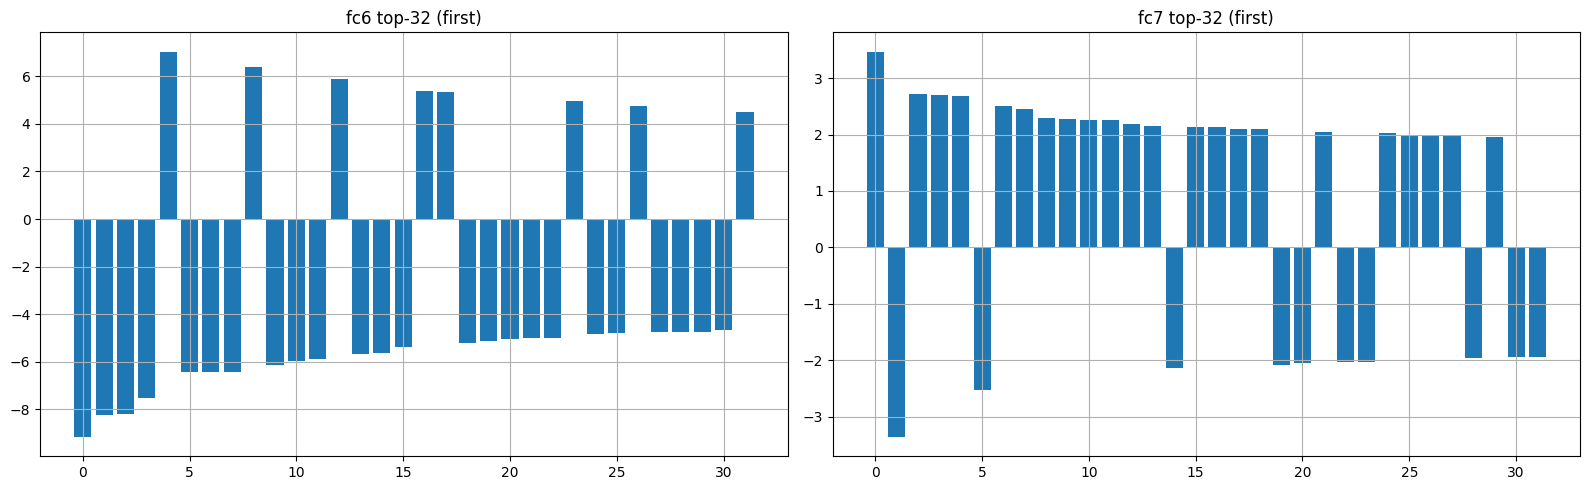

<Figure size 640x480 with 0 Axes>

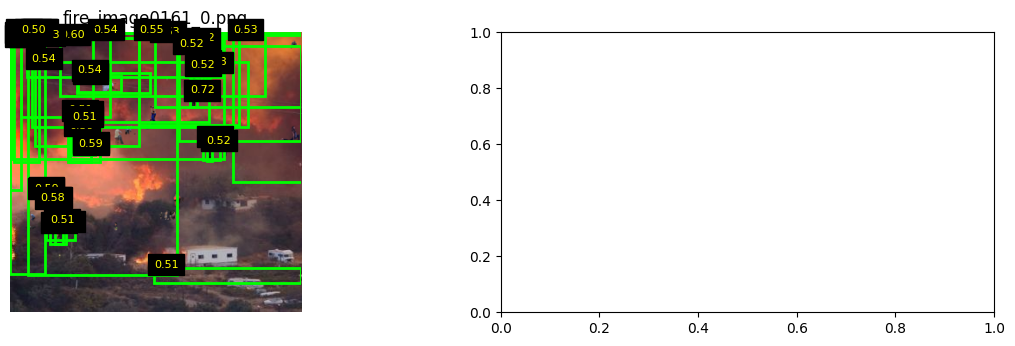

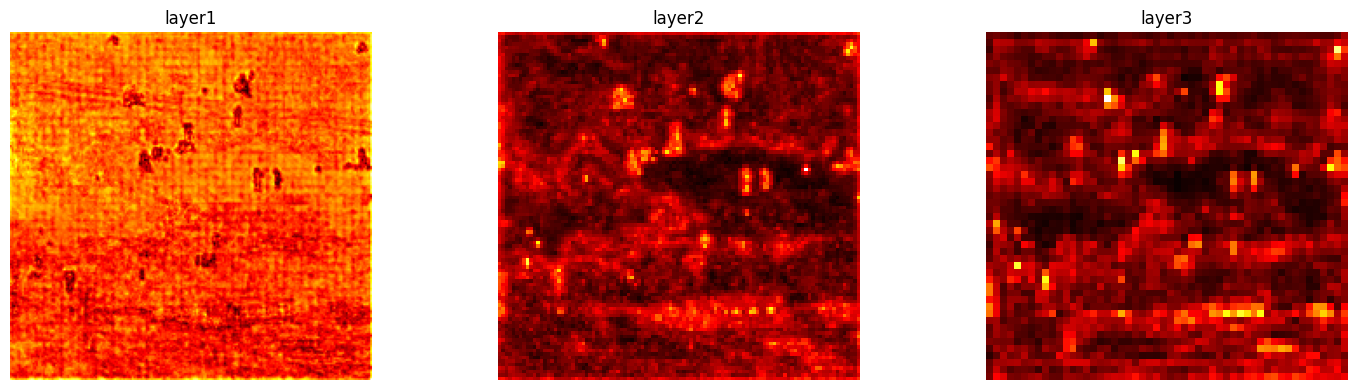

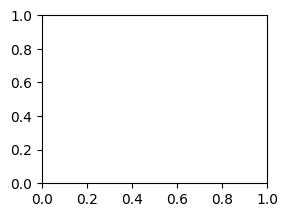

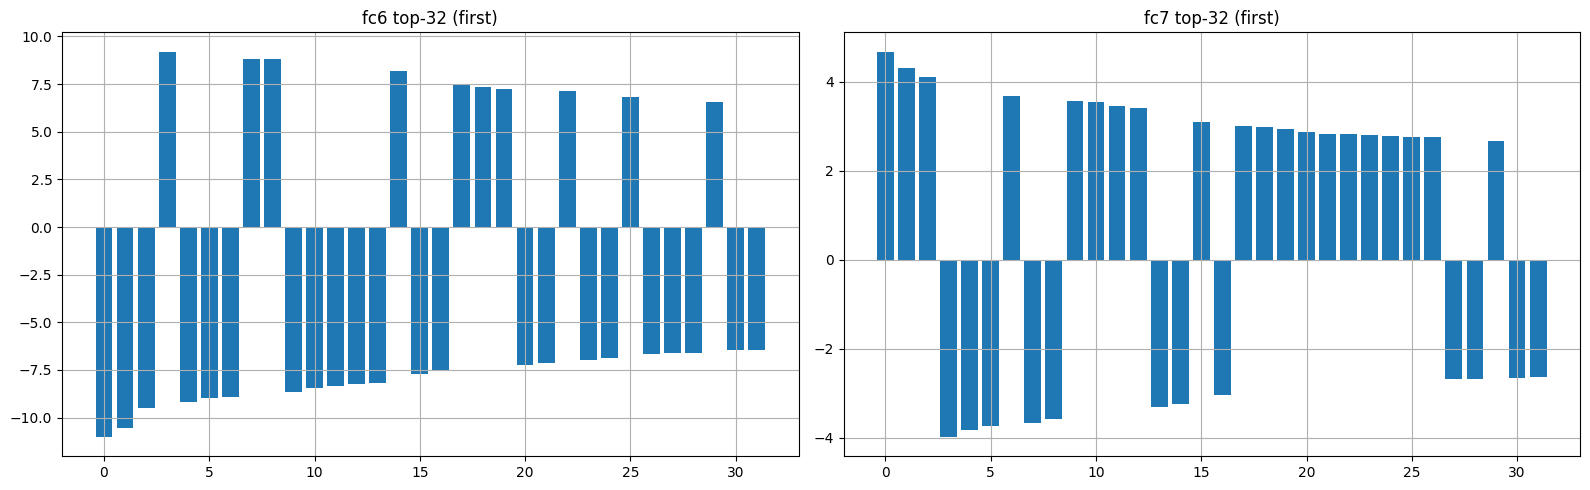

<Figure size 640x480 with 0 Axes>

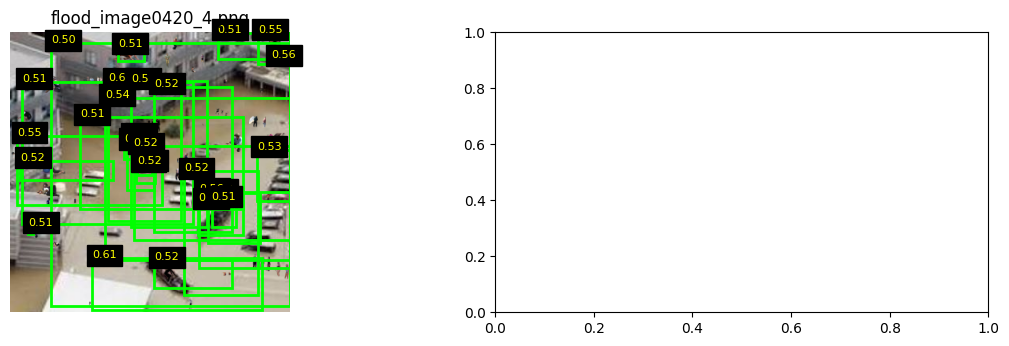

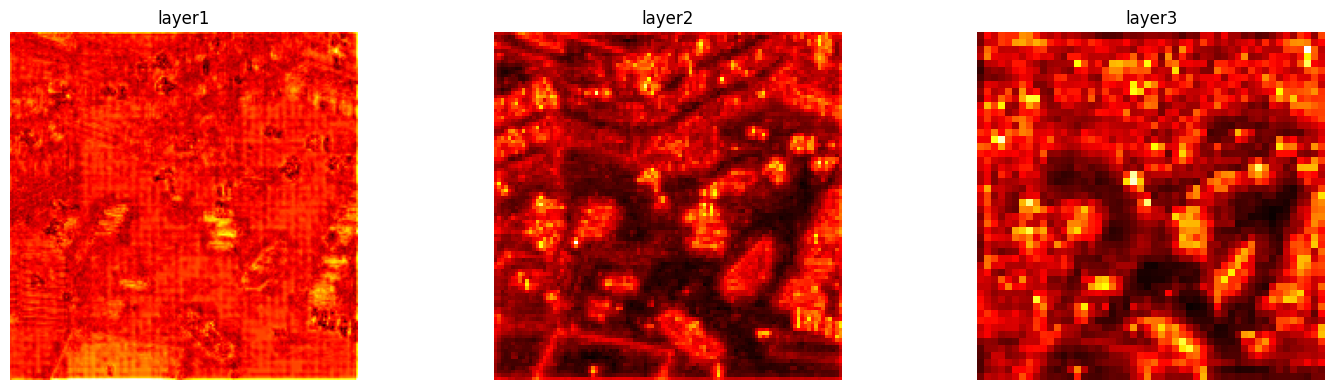

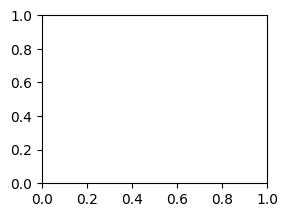

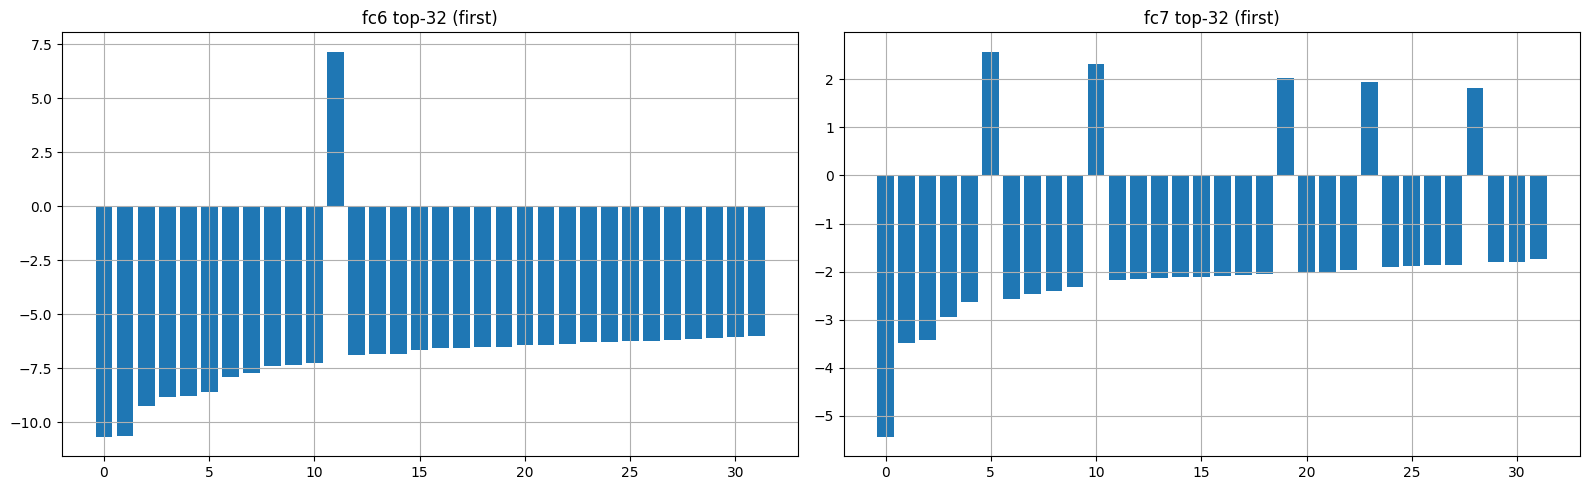

<Figure size 640x480 with 0 Axes>

In [8]:
# Visualize 5 specified images (feature maps + dense activations)
try:
    root
except NameError:
    import os
    root = os.getcwd()
select_dir = os.path.join(root, 'C2A_selected')
selected_files = [
    'collapsed_building_image0100_4.png',
    'collapsed_building_image0102_1.png',
    'collapsed_building_image0103_4.png',
    'fire_image0161_0.png',
    'flood_image0420_4.png',
]
print('Selected images path:', select_dir)

def load_image_tensor(img_path):
    img = cv2.imread(img_path)
    assert img is not None, f'Cannot read {img_path}'
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.0
    t = torch.from_numpy(img).permute(2,0,1)
    return t

# Enable hooks only during visualization
HOOKS_ENABLED = True
reset_hooks_buffers()
for i, fname in enumerate(selected_files):
    path = os.path.join(select_dir, fname)
    img_t = load_image_tensor(path)
    pred = run_inference_with_hooks(model, img_t)
    img_np = tensor_to_np(img_t)
    # Figure per image
    fig = plt.figure(figsize=(14,8))
    ax = plt.subplot(2,2,1)
    draw_detections(ax, img_np, pred, score_thr=0.5)
    ax.set_title(fname)
    plt.subplot(2,2,2)
    show_feature_maps(feature_maps)
    plt.subplot(2,2,3)
    show_dense_activations(dense_acts, topk=32, agg='first')
    plt.tight_layout(); plt.show(); plt.close(fig)
    # Clear for next image
    reset_hooks_buffers()
HOOKS_ENABLED = False
reset_hooks_buffers()
gc.collect()
if device.type=='cuda': torch.cuda.empty_cache()

In [1]:
# Training and evaluation utilities
def collate_fn(batch):
    return tuple(zip(*batch))

def compute_bbox_metrics(matches):
    # matches: list of tuples (pred_box, gt_box) for matched pairs
    if not matches:
        return {'mae': None, 'mse': None, 'r2': None}
    diffs = []
    for pb, gb in matches:
        diffs.append((pb - gb).cpu().numpy())
    diffs = np.stack(diffs)  # N x 4
    mae = float(np.mean(np.abs(diffs)))
    mse = float(np.mean(diffs**2))
    # r2 across each coord then mean
    y = np.stack([gb.cpu().numpy() for _, gb in matches])
    yhat = np.stack([pb.cpu().numpy() for pb, _ in matches])
    ss_res = np.sum((y - yhat)**2, axis=0)
    ss_tot = np.sum((y - y.mean(axis=0))**2, axis=0) + 1e-9
    r2_vec = 1 - ss_res/ss_tot
    r2 = float(np.mean(r2_vec))
    return {'mae': mae, 'mse': mse, 'r2': r2}

def box_iou_xyxy(boxes1, boxes2):
    # boxes: Nx4, Mx4
    area1 = (boxes1[:,2]-boxes1[:,0]).clamp(min=0) * (boxes1[:,3]-boxes1[:,1]).clamp(min=0)
    area2 = (boxes2[:,2]-boxes2[:,0]).clamp(min=0) * (boxes2[:,3]-boxes2[:,1]).clamp(min=0)
    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    wh = (rb - lt).clamp(min=0)
    inter = wh[:,:,0]*wh[:,:,1]
    union = area1[:,None] + area2 - inter + 1e-9
    iou = inter/union
    return iou

def evaluate_val(model, loader, score_thr=0.3, iou_thr=0.5, max_batches=None):
    model.eval()
    total_tp=0; total_pred=0; total_gt=0; all_matches=[]
    with torch.no_grad():
        for bi, (imgs, targets) in enumerate(loader):
            if max_batches is not None and bi>=max_batches: break
            imgs = [img.to(device) for img in imgs]
            outs = model(imgs)
            for out, tgt in zip(outs, targets):
                pb = out['boxes'][out['scores']>=score_thr] if 'scores' in out else out['boxes']
                gb = tgt['boxes'].to(device) if isinstance(tgt, dict) else tgt["boxes"].to(device)
                total_pred += int(pb.shape[0]); total_gt += int(gb.shape[0])
                if pb.numel()==0 or gb.numel()==0: continue
                iou = box_iou_xyxy(pb, gb)
                # greedy matching
                used_pred=set(); used_gt=set()
                while True:
                    iou_max, idx = (iou.max(), torch.argmax(iou)) if iou.numel()>0 else (None, None)
                    if iou_max is None or iou_max < iou_thr: break
                    p_idx = int(idx // iou.shape[1]); g_idx = int(idx % iou.shape[1])
                    if p_idx in used_pred or g_idx in used_gt:
                        iou[p_idx, g_idx] = -1; continue
                    used_pred.add(p_idx); used_gt.add(g_idx)
                    total_tp += 1
                    all_matches.append((pb[p_idx].detach().cpu(), gb[g_idx].detach().cpu()))
                    iou[p_idx, g_idx] = -1
    recall = total_tp/total_gt if total_gt>0 else 0.0
    acc_proxy = recall
    metrics = compute_bbox_metrics(all_matches)
    return {'recall@0.5': recall, 'acc_proxy': acc_proxy, **metrics}

def train_one_epoch(model, loader, optimizer, scaler=None, max_batches=None, log_interval=50):
    model.train()
    running_loss=0.0; n=0
    for bi, (imgs, targets) in enumerate(loader):
        if max_batches is not None and bi>=max_batches: break
        imgs = [img.to(device) for img in imgs]
        tgts = [{k: v.to(device) if torch.is_tensor(v) else v for k,v in t.items()} for t in targets]
        optimizer.zero_grad(set_to_none=True)
        if scaler is not None:
            with torch.cuda.amp.autocast():
                losses = model(imgs, tgts)
                loss = sum(v for v in losses.values())
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            losses = model(imgs, tgts)
            loss = sum(v for v in losses.values())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
        running_loss += float(loss.detach().cpu())
        n += 1
        if (bi+1) % log_interval == 0:
            print(f'  [batch {bi+1}] loss: {running_loss/n:.4f}')
        # memory hygiene
        del imgs, tgts, losses, loss
        gc.collect()
        if device.type=='cuda': torch.cuda.empty_cache()
    return running_loss/max(n,1)

def train_and_eval(model, train_loader, val_loader, epochs=2, max_train_batches=None, max_val_batches=None):
    history={'train_loss':[], 'recall':[], 'mae':[], 'mse':[], 'r2':[]}
    scaler = torch.cuda.amp.GradScaler() if device.type=='cuda' else None
    for ep in range(1, epochs+1):
        print(f'Epoch {ep}/{epochs}')
        tl = train_one_epoch(model, train_loader, optimizer, scaler, max_batches=max_train_batches)
        eval_res = evaluate_val(model, val_loader, score_thr=0.3, iou_thr=0.5, max_batches=max_val_batches)
        history['train_loss'].append(tl)
        history['recall'].append(eval_res['recall@0.5'])
        history['mae'].append(eval_res['mae'] if eval_res['mae'] is not None else np.nan)
        history['mse'].append(eval_res['mse'] if eval_res['mse'] is not None else np.nan)
        history['r2'].append(eval_res['r2'] if eval_res['r2'] is not None else np.nan)
        print(f"  train_loss={tl:.4f} recall@0.5={history['recall'][-1]:.3f} mae={history['mae'][-1]} mse={history['mse'][-1]} r2={history['r2'][-1]}")
        # save checkpoint
        os.makedirs('checkpoints', exist_ok=True)
        torch.save({'model': model.state_dict()}, os.path.join('checkpoints','fasterrcnn_ckpt.pth'))
        gc.collect();
        if device.type=='cuda': torch.cuda.empty_cache()
    return history

def plot_history(history):
    fig, axs = plt.subplots(1,5, figsize=(20,4))
    axs[0].plot(history['train_loss']); axs[0].set_title('Train Loss')
    axs[1].plot(history['recall']); axs[1].set_title('Recall@0.5')
    axs[2].plot(history['mae']); axs[2].set_title('MAE')
    axs[3].plot(history['mse']); axs[3].set_title('MSE')
    axs[4].plot(history['r2']); axs[4].set_title('R2')
    for ax in axs: ax.grid(True)
    plt.tight_layout(); plt.show(); plt.close(fig)

In [2]:
# Run short training + evaluation and plot
# Make sure hooks are disabled during training
HOOKS_ENABLED = False
reset_hooks_buffers()
gc.collect()
if device.type=='cuda': torch.cuda.empty_cache()
history = train_and_eval(model, train_loader, val_loader, epochs=2, max_train_batches=50, max_val_batches=50)
plot_history(history)

NameError: name 'reset_hooks_buffers' is not defined

In [ ]:
# Grad-CAM for Faster R-CNN backbone.layer3
class GradCAM:
    def __init__(self, model, target_module):
        self.model = model
        self.target_module = target_module
        self.activations=None; self.gradients=None
        self.h1 = target_module.register_forward_hook(self.fwd)
        self.h2 = target_module.register_full_backward_hook(self.bwd)
    def fwd(self, m, i, o):
        self.activations = o.detach()
    def bwd(self, m, gi, go):
        self.gradients = go[0].detach()
    def __del__(self):
        try: self.h1.remove(); self.h2.remove()
        except: pass
    def __call__(self, img_tensor, pred_idx=0):
        self.model.eval()
        img_tensor = img_tensor.to(device)
        out = self.model([img_tensor])[0]
        if out['scores'].numel()==0:
            return tensor_to_np(img_tensor), None, out
        # take top-1 detection score as target
        score = out['scores'][pred_idx]
        # need a scalar to backprop; sum for safety
        loss = score
        self.model.zero_grad()
        loss.backward(retain_graph=False)
        A = self.activations
        G = self.gradients
        if A is None or G is None:
            return tensor_to_np(img_tensor), None, out
        weights = G.mean(dim=(2,3), keepdim=True)
        cam = (weights * A).sum(dim=1, keepdim=False)
        cam = torch.relu(cam)
        cam = cam[0].detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max()-cam.min() + 1e-9)
        cam = cam.mean(axis=0)
        img_np = tensor_to_np(img_tensor)
        H,W = img_np.shape[:2]
        cam_resized = cv2.resize(cam, (W,H))
        heatmap = (plt.cm.jet(cam_resized)[:,:,:3] * 255).astype(np.uint8)
        overlay = (0.5*heatmap + 255*img_np).clip(0,255).astype(np.uint8)
        return img_np, overlay, out

# Run Grad-CAM on a correct and an incorrect case if possible
gc_obj = GradCAM(model, model.backbone.body.layer3)
def show_gradcam_case(img_path, title):
    t = load_image_tensor(img_path)
    img_np, overlay, out = gc_obj(t)
    fig = plt.figure(figsize=(10,4))
    ax1 = plt.subplot(1,2,1); ax1.imshow(img_np); ax1.set_title(title + ' - input'); ax1.axis('off')
    if overlay is not None:
        ax2 = plt.subplot(1,2,2); ax2.imshow(overlay); ax2.set_title(title + ' - GradCAM'); ax2.axis('off')
    else:
        ax2 = plt.subplot(1,2,2); ax2.imshow(img_np); ax2.set_title(title + ' - no detections'); ax2.axis('off')
    plt.tight_layout(); plt.show(); plt.close(fig)

# Try on one "similar" and one "different" image
show_gradcam_case(os.path.join(select_dir, 'collapsed_building_image0102_1.png'), 'Similar sample')
show_gradcam_case(os.path.join(select_dir, 'fire_image0161_0.png'), 'Different sample')
del gc_obj; gc.collect();
if device.type=='cuda': torch.cuda.empty_cache()

In [ ]:
# Ensure patches import for drawing boxes
from matplotlib import patches